<a href="https://colab.research.google.com/github/mkbahk/AmazonBraket/blob/main/QuantumApplicationAlgorithm_VQA_QAOA(TSP)_mkbahk_20260203.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
# Python 3.9 ~ 3.11 환경에서 아래 순서대로 설치
%pip install qiskit[visualization]==1.2.4
%pip install qiskit-aer==0.15.1
%pip install qiskit-algorithms==0.3.1
%pip install qiskit-optimization==0.7.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 7.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 79.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 108.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 20.3 MB/s eta 0:00:00
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=74f4dfc05986a30ae9d08e18c08d5ce2fb042cd92e853e3785be32d0654fe060
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 101.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 310.5/310.5 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 647.4/647.4 kB 20.6 MB/s eta 0:00:00
  Installing build dependencie

**필요 패키지 설치 및 import**

In [5]:
# 필요한 패키지 설치 (터미널에서 실행)
# pip install qiskit qiskit-optimization qiskit-aer qiskit-algorithms

from qiskit_optimization.applications import Tsp
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit_algorithms.minimum_eigensolvers import QAOA # Updated import
from qiskit_algorithms.optimizers import COBYLA # Updated import
from qiskit.primitives import Sampler # Corrected import for Sampler
from qiskit_optimization.algorithms import MinimumEigenOptimizer
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

1. TSP 인스턴스 생성<br>
3개의 도시를 가진 랜덤 TSP 그래프를 생성합니다. 각 도시 간 거리는 랜덤으로 설정됩니다.

In [6]:
# 도시 수 (작은 예제로 3개 사용)
n = 3

# 랜덤 TSP 인스턴스 생성
tsp = Tsp.create_random_instance(n, seed=123)  # seed로 재현성 확보
adj_matrix = nx.to_numpy_array(tsp.graph)  # 인접 행렬 추출

print("거리 행렬:")
print(adj_matrix)

거리 행렬:
[[ 0. 48. 91.]
 [48.  0. 63.]
 [91. 63.  0.]]


2. TSP를 Quadratic Program으로 변환<br>
TSP 문제를 이차 계획 문제(QP)로 변환합니다. 이는 QAOA가 처리할 수 있는 형태입니다.

In [7]:
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

Problem name: TSP

Minimize
  48*x_0_0*x_1_1 + 48*x_0_0*x_1_2 + 91*x_0_0*x_2_1 + 91*x_0_0*x_2_2
  + 48*x_0_1*x_1_0 + 48*x_0_1*x_1_2 + 91*x_0_1*x_2_0 + 91*x_0_1*x_2_2
  + 48*x_0_2*x_1_0 + 48*x_0_2*x_1_1 + 91*x_0_2*x_2_0 + 91*x_0_2*x_2_1
  + 63*x_1_0*x_2_1 + 63*x_1_0*x_2_2 + 63*x_1_1*x_2_0 + 63*x_1_1*x_2_2
  + 63*x_1_2*x_2_0 + 63*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2



3. QAOA 설정 및 실행 (Aer Simulator 사용)<br>
Aer Simulator를 기반으로 한 Sampler를 사용해 QAOA를 실행합니다. 여기서 reps=1로 간단히 설정했으나, 더 나은 근사를 위해 reps를 증가시킬 수 있습니다.

In [8]:
# QP를 QUBO로 변환 (QAOA가 필요로 함)
converter = QuadraticProgramToQubo()
qubo = converter.convert(qp)

# Sampler 설정 (Aer Simulator 사용)
# QAOA는 기댓값을 계산하기 위해 Sampler를 필요로 합니다.
from qiskit_aer.primitives import Sampler # Sampler를 임포트합니다.
sampler = Sampler() # Sampler 인스턴스를 생성합니다.

# Optimizer 설정 (클래식 최적화)
optimizer = COBYLA()

# QAOA 인스턴스 생성
# QAOA는 'sampler' 파라미터를 기대합니다.
qaoa = QAOA(sampler=sampler, optimizer=optimizer, reps=1)  # reps: QAOA 레이어 수

# MinimumEigenOptimizer로 QAOA 래핑
qaoa_optimizer = MinimumEigenOptimizer(qaoa)

# 문제 해결
result = qaoa_optimizer.solve(qp)
print(result.prettyprint())

objective function value: 202.0
variable values: x_0_0=0.0, x_0_1=1.0, x_0_2=0.0, x_1_0=1.0, x_1_1=0.0, x_1_2=0.0, x_2_0=0.0, x_2_1=0.0, x_2_2=1.0
status: SUCCESS


4. 결과 해석 및 시각화<br>
QAOA 결과에서 최적 경로를 추출하고 시각화합니다.

최적 경로: [1, 0, 2]


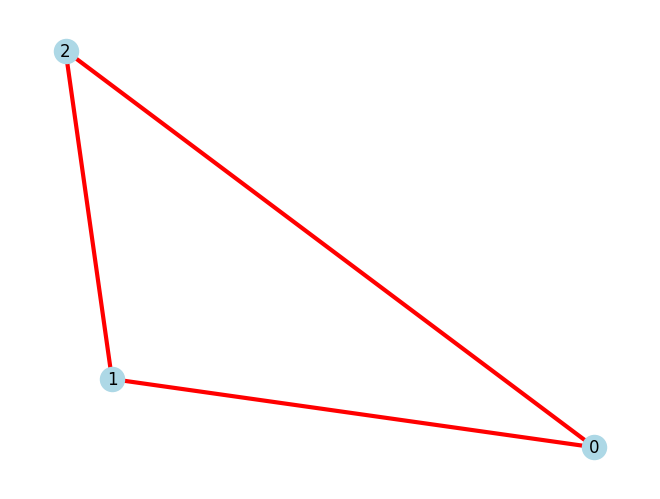

In [9]:
# 결과에서 TSP 경로 추출
def get_tsp_solution(result, n):
    x = result.x
    route = [-1] * n
    for i in range(n):
        for j in range(n):
            if x[j * n + i] == 1:
                route[i] = j
            ###if
        ###for
    ###for
    return route
###def

route = get_tsp_solution(result, n)
print("최적 경로:", route)

# 그래프 시각화
G = nx.Graph()
for i in range(n):
    G.add_node(i)
###for

pos = {i: (tsp.graph.nodes[i]["pos"][0], tsp.graph.nodes[i]["pos"][1]) for i in range(n)}

# 전체 그래프 그리기
nx.draw(G, pos=pos, with_labels=True, node_color="lightblue")

# 최적 경로 강조
# 유효한 노드 인덱스만 사용하여 경로를 구성하여 KeyError를 방지합니다.
path_edges = []
for i in range(n):
    node1 = route[i]
    node2 = route[(i + 1) % n]
    if node1 != -1 and node2 != -1: # -1이 아닌 유효한 노드만 추가
        path_edges.append((node1, node2))
    ###if
###for

# 유효한 경로 엣지가 있을 경우에만 그립니다.
if path_edges:
    nx.draw_networkx_edges(G, pos=pos, edgelist=path_edges, edge_color="red", width=3)
else:
    print("경로를 그릴 유효한 엣지를 찾을 수 없습니다. QAOA 솔루션이 유효하지 않을 수 있습니다.")
###if

plt.show()